In [1]:
import pandas as pd
import yfinance as yf
from webapp.fincalc.portfolio_analytics import calculate_stock_volatility, check_volatility_signal
import numpy as np
import matplotlib.ticker as mticker # For formatting y-axis as percentage
import numpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from mlfinpy.data_structure import standard_bars
from mlfinpy.data_structure import get_time_bars, get_volume_bars, get_dollar_bars, get_tick_bars
from backtester.utils import calculate_volume_bar_threshold


In [55]:
tickets = ["IONQ", "QUBT", "RGTI", "QMCO"]
ionq_tk = tickets[0]
data_raw = yf.download(ionq_tk, period="30d", interval="1h", progress=False, prepost=True)
data_single_ticker = data_raw.xs(ionq_tk, level=1, axis=1).copy()
data_single_ticker

Price,Close,High,Low,Open,Volume
Datetime,,,,,
2025-03-14 08:00:00+00:00,22.05,22.110000,21.570000,22.0000,0
2025-03-14 09:00:00+00:00,22.05,22.140000,21.910000,22.0600,0
2025-03-14 10:00:00+00:00,21.64,22.060000,21.560000,22.0500,0
2025-03-14 11:00:00+00:00,21.90,21.990000,21.580000,21.6400,0
2025-03-14 12:00:00+00:00,22.32,22.420000,21.590000,21.9300,0
...,...,...,...,...,...
2025-04-25 19:30:00+00:00,28.92,28.959999,28.610001,28.6709,1322050
2025-04-25 20:00:00+00:00,28.62,28.970000,28.600000,28.9000,0
2025-04-25 21:00:00+00:00,28.72,28.790000,28.600000,28.6003,0


In [56]:
data_ml = data_single_ticker[['Close', 'Volume']].copy()
data_ml.rename(columns={'Datetime':'date','Close': 'price', 'Volume': 'volume'}, inplace=True)


data_ml

Price,price,volume
Datetime,,
2025-03-14 08:00:00+00:00,22.05,0
2025-03-14 09:00:00+00:00,22.05,0
2025-03-14 10:00:00+00:00,21.64,0
2025-03-14 11:00:00+00:00,21.90,0
2025-03-14 12:00:00+00:00,22.32,0
...,...,...
2025-04-25 19:30:00+00:00,28.92,1322050
2025-04-25 20:00:00+00:00,28.62,0
2025-04-25 21:00:00+00:00,28.72,0


In [57]:

target_bars = 50
calculate_volume_bar_threshold(data_ml, target_bars_per_day=target_bars)


Error: Volume column 'Volume' not found in DataFrame.


nan

In [58]:
from backtester.strategies import generate_bollinger_bands_signals

volume_bars_df = get_volume_bars(data_ml,threshold=402150, verbose=False)
volume_bar_closes = volume_bars_df['close']
window_size = 10 # Number of volume bars
num_std_dev = 0.5  # Number of standard deviations

# Use the existing function from strategies.py
signals = generate_bollinger_bands_signals(volume_bar_closes, window=window_size, num_std=num_std_dev)

signals

0      0
1      0
2      0
3      0
4      0
      ..
205    0
206   -1
207    0
208    0
209   -1
Length: 210, dtype: int64

In [59]:
data_ml

Price,price,volume
Datetime,,
2025-03-14 08:00:00+00:00,22.05,0
2025-03-14 09:00:00+00:00,22.05,0
2025-03-14 10:00:00+00:00,21.64,0
2025-03-14 11:00:00+00:00,21.90,0
2025-03-14 12:00:00+00:00,22.32,0
...,...,...
2025-04-25 19:30:00+00:00,28.92,1322050
2025-04-25 20:00:00+00:00,28.62,0
2025-04-25 21:00:00+00:00,28.72,0


Generating volume bars...
--- Volume Threshold Calculation ---
Num Trading Days: 30, Total Vol: 603,225,968, Avg Daily Vol: 20,107,532
Target Bars/Day: 50, Estimated Threshold: 402,151
---------------------------------
Generated 210 volume bars.
Running Bollinger Bands strategy (window=20, num_std=0.5) on volume bars...
Bollinger Bands signals generated.
Running backtest simulation on volume bars...
Backtest simulation finished.

--- Performance Metrics ---
Initial Portfolio Value: $1,000.00
Final Portfolio Value:   $1,257.06
Total Return:            25.71%
Maximum Drawdown:        -14.11%
Number of Trades:        12
Total Commission Paid:  $12.00
---------------------------



/Users/abatutin/Documents/projects/interactive-brokers-web-api/backtester/simple_backtester.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.8700065612793' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.loc[timestamp, 'cash'] = cash


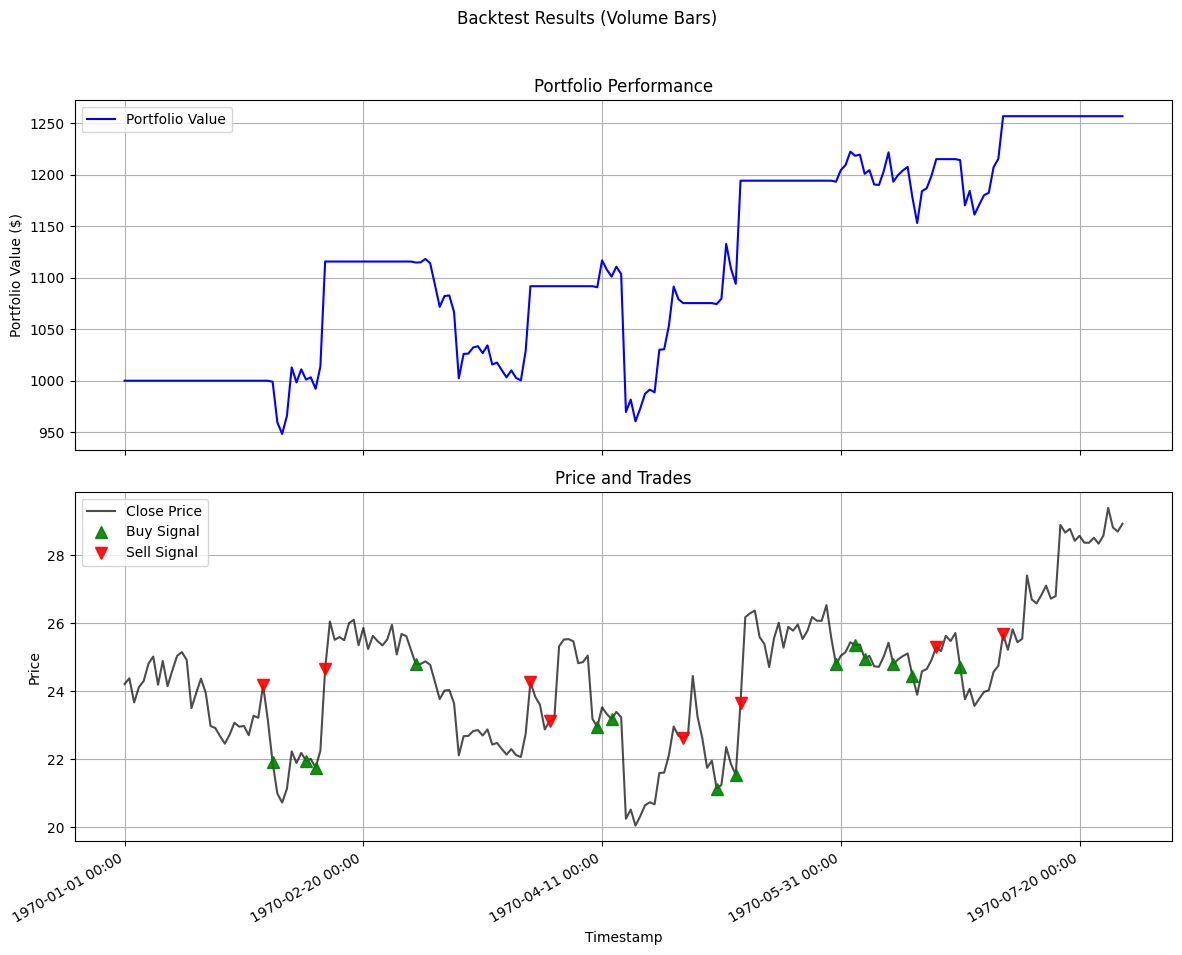

In [61]:
from backtester.simple_backtester import SimpleBacktester

bb_params = {
        'window': 20,    # 20-day SMA
        'num_std': .5   # 2 standard deviations
    }


backtester_vol = SimpleBacktester(
    data_ml,
  initial_cash=1000,
  commission_per_trade=1.0,
  bar_type='volume',
  target_bars_per_day=50,

)
# Option 2: Provide specific threshold
# backtester_vol = SimpleBacktester(data_raw, initial_cash=100000, commission_per_trade=1.0,
#                                 bar_type='volume', volume_threshold=500000)

backtester_vol.run_bollinger_bands(**bb_params)
backtester_vol.run_backtest()
backtester_vol.plot_results()
